# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

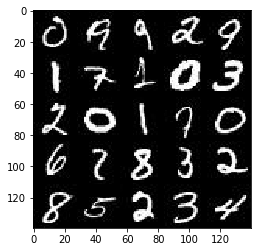

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

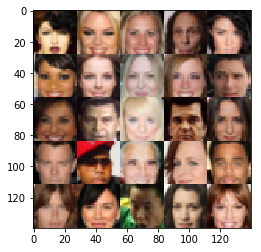

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_images')
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim], name='z_dim')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        output_tensor1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        leaky_relu1 = tf.maximum(0.1 * output_tensor1, output_tensor1)

        out_tensor2 = tf.layers.conv2d(leaky_relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(out_tensor2, training=True)
        leaky_relu2 = tf.maximum(0.1 * bn2, bn2)
        
        out_tensor3 = tf.layers.conv2d(leaky_relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(out_tensor3, training=True)
        leaky_relu3 = tf.maximum(0.1 * bn3, bn3)

        flat = tf.reshape(leaky_relu3, (-1, 4*4*224))
        
        d_logits = tf.layers.dense(flat, 1, activation=None)
        d_output = tf.sigmoid(d_logits)

    return d_output, d_logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse= not is_train):
        output_tensor = tf.layers.dense(z,4*4*448)
        output_tensor = tf.reshape(output_tensor, (-1,4,4,448))
        output_tensor = tf.layers.batch_normalization(output_tensor, training=is_train)
        output_tensor = tf.maximum(0.1 * output_tensor, output_tensor)

        output_tensor = tf.layers.conv2d_transpose(output_tensor, 224, 3, strides=2, padding='same')
        output_tensor = tf.layers.batch_normalization(output_tensor, training=is_train)
        output_tensor = tf.maximum(0.1 * output_tensor, output_tensor)

        output_tensor = tf.layers.conv2d_transpose(output_tensor, 112, 3, strides=2, padding='same')
        output_tensor = tf.layers.batch_normalization(output_tensor, training=is_train)
        output_tensor = tf.maximum(0.1 * output_tensor, output_tensor)
        
        output_tensor = tf.layers.conv2d_transpose(output_tensor, out_channel_dim, 3, strides=2, padding='same')
        g_logits = tf.image.resize_images(output_tensor, [28,28])
        g_output = tf.tanh(g_logits)
    return g_output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)


    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)* 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    g_vars = [x for x in train_vars if x.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt,g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    import pickle as pkl
    samples, losses = [], []
    epoch = 0
    input_images, z_data, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_images, z_data, data_shape[3])
    d_train_opt,g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                epoch += 1

                _ = sess.run(d_train_opt, feed_dict={input_images:batch_images, z_data:batch_z, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_data:batch_z, input_images:batch_images, learn_rate:learning_rate})
                
                if epoch % 10 ==0:
                    train_loss_d = d_loss.eval({z_data: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({z_data: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    losses.append((train_loss_d, train_loss_g))
                    
                if epoch % 100 == 0:
                    show_generator_output(sess, input_images.get_shape()[2], z_data, data_shape[3], data_image_mode)
                    
        tf.train.Saver().save(sess, './generator.ckpt')
    
    return losses, samples

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 4.8662
Epoch 1/2... Discriminator Loss: 0.4226... Generator Loss: 4.3872
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 4.4412
Epoch 1/2... Discriminator Loss: 3.7480... Generator Loss: 0.2724
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.7418
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 2.5883
Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 3.9883
Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 5.2845
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.5367
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.9542


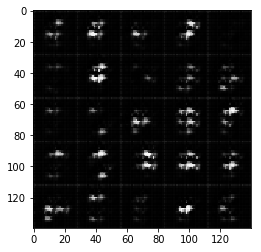

Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 1.6532
Epoch 1/2... Discriminator Loss: 1.7428... Generator Loss: 0.4180
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 2.9055
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 2.3890... Generator Loss: 6.9007
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 1.7021
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 1.7177


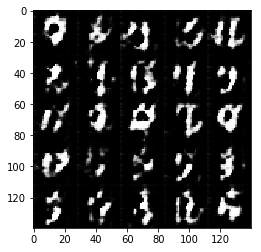

Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 2.4338
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.2820
Epoch 1/2... Discriminator Loss: 1.7338... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 1.8543
Epoch 1/2... Discriminator Loss: 1.7371... Generator Loss: 4.0295
Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 1.0697
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 2.4715
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 2.0875


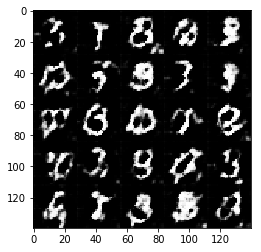

Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 2.1335
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.2766
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 2.1717
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 1.5027
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 2.0763
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.3306
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 3.0516
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 1.8842
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 2.1602
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 2.3033


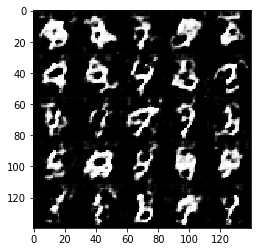

Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 1.6352
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 1.7712
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.8109
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.8939
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 1.5648
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 1.6406
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 2.1701


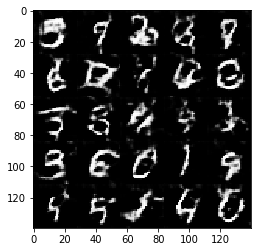

Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 2.1169
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 2.2696
Epoch 1/2... Discriminator Loss: 1.7717... Generator Loss: 0.4103
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.4586
Epoch 1/2... Discriminator Loss: 1.6707... Generator Loss: 0.4001


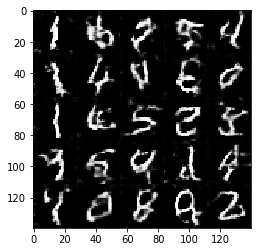

Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.7006... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.5682
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 1.0204
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 1.0027
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.4126
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 1.9431
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.6432
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.6613


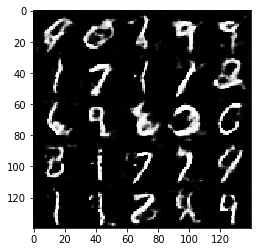

Epoch 1/2... Discriminator Loss: 1.5305... Generator Loss: 0.4646
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 1.5835
Epoch 1/2... Discriminator Loss: 1.7819... Generator Loss: 0.3667
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 2.1829
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 1.9396
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 0.8822... Generator Loss: 1.6431
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.1372
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.5329


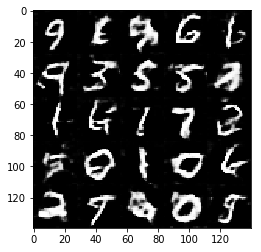

Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.5604
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 2.6474... Generator Loss: 4.3532
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 0.8695
Epoch 1/2... Discriminator Loss: 0.8507... Generator Loss: 1.8410
Epoch 1/2... Discriminator Loss: 2.3540... Generator Loss: 0.2033
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.7587


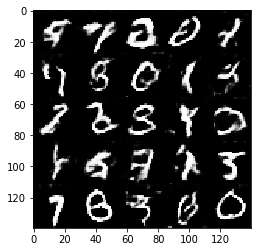

Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 1.8296
Epoch 1/2... Discriminator Loss: 1.4407... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.5003
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.4420
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 1.7389
Epoch 1/2... Discriminator Loss: 1.7836... Generator Loss: 3.5277
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.8182
Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.4272


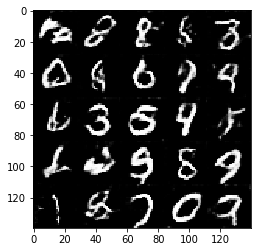

Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 2.4637
Epoch 1/2... Discriminator Loss: 1.6002... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.7484... Generator Loss: 0.3643
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.7843... Generator Loss: 0.3729
Epoch 1/2... Discriminator Loss: 1.9580... Generator Loss: 0.2892
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.8117
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.6388
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 0.4431


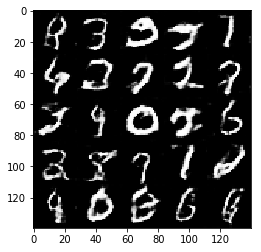

Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 1.5250
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 1.6351
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.4641
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 1.1439
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.5632


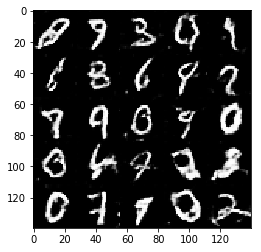

Epoch 1/2... Discriminator Loss: 1.6419... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 1.3212
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.3668
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 2.5567... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 0.9126... Generator Loss: 1.2547
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.1277
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.5130
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 1.8253


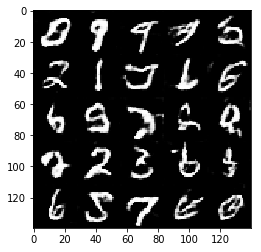

Epoch 1/2... Discriminator Loss: 1.7884... Generator Loss: 0.3964
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 0.7236... Generator Loss: 1.6226
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 0.7389
Epoch 1/2... Discriminator Loss: 1.6760... Generator Loss: 0.3731
Epoch 1/2... Discriminator Loss: 1.5532... Generator Loss: 0.5210
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 0.9402
Epoch 1/2... Discriminator Loss: 1.7691... Generator Loss: 0.3721
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.7555


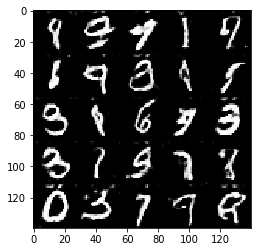

Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 1.7197... Generator Loss: 0.3804
Epoch 1/2... Discriminator Loss: 1.9495... Generator Loss: 0.3218
Epoch 1/2... Discriminator Loss: 2.3139... Generator Loss: 0.2555
Epoch 1/2... Discriminator Loss: 0.9867... Generator Loss: 1.1373
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 2.2257
Epoch 1/2... Discriminator Loss: 1.6950... Generator Loss: 0.3904
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 1.2601
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.1644


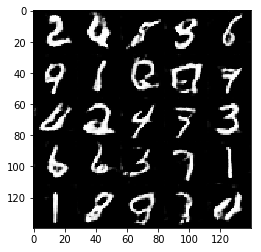

Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 1.2269
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.6750
Epoch 1/2... Discriminator Loss: 1.4954... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 2.4551
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.3666
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 1.1869
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 2.1237


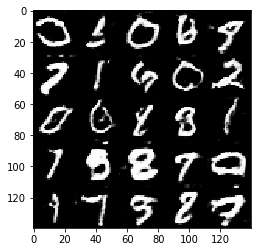

Epoch 1/2... Discriminator Loss: 1.4535... Generator Loss: 0.5268
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 1.2956
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 0.6350... Generator Loss: 2.0257
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.5386
Epoch 1/2... Discriminator Loss: 0.6455... Generator Loss: 1.8882
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 1.2959
Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 0.4565
Epoch 1/2... Discriminator Loss: 1.1431... Generator Loss: 1.0537


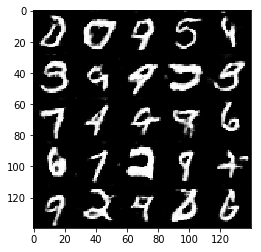

Epoch 1/2... Discriminator Loss: 2.0912... Generator Loss: 0.3088
Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.2005
Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 1.4221
Epoch 1/2... Discriminator Loss: 0.6822... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 1.7238... Generator Loss: 0.3921
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.9365


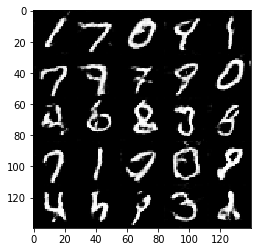

Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.4679
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.7378
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.6054
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.8135
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.5096
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 1.8865... Generator Loss: 0.3959
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 0.7396


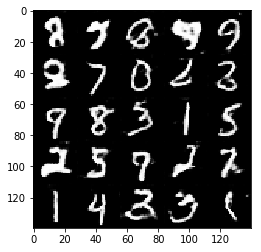

Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 1.0521
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.7589
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.6753
Epoch 2/2... Discriminator Loss: 1.6334... Generator Loss: 0.4332
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 1.5329
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 1.0517


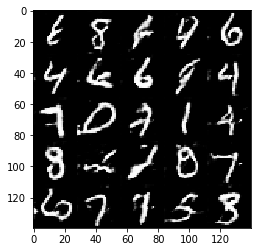

Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 1.1399... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 2.1135
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 2.4112
Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 1.1944
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 1.7980


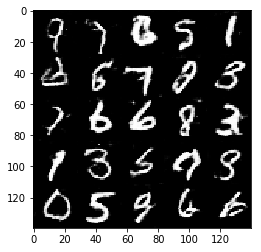

Epoch 2/2... Discriminator Loss: 1.6044... Generator Loss: 0.4642
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.1124
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.7263


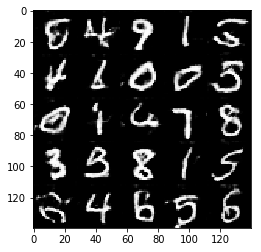

Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.2061
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.6720
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 1.6884
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.7379
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 1.2053
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.8869


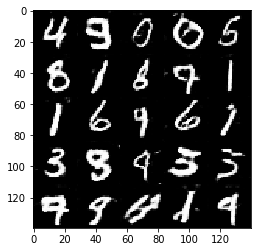

Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 1.5738... Generator Loss: 0.5714
Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 1.2115
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.3922
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.6048... Generator Loss: 0.4176
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 0.6918... Generator Loss: 2.0718
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.6015


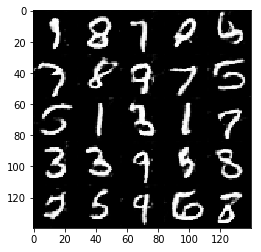

Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.9778
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.2219
Epoch 2/2... Discriminator Loss: 0.9315... Generator Loss: 1.4296
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.8261
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 1.1907
Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 1.0041
Epoch 2/2... Discriminator Loss: 1.7088... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 2.2018... Generator Loss: 0.2865
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 0.8951


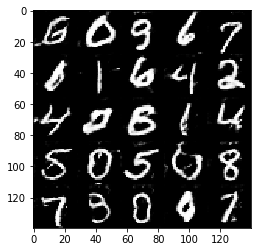

Epoch 2/2... Discriminator Loss: 1.5865... Generator Loss: 0.4648
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 1.4142
Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 0.4501
Epoch 2/2... Discriminator Loss: 1.6290... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.4157
Epoch 2/2... Discriminator Loss: 1.6230... Generator Loss: 0.5119
Epoch 2/2... Discriminator Loss: 1.5537... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.8838
Epoch 2/2... Discriminator Loss: 2.3438... Generator Loss: 0.2513
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 1.2503


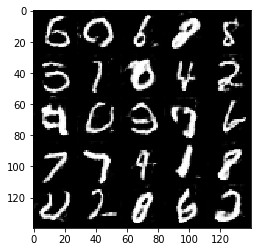

Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 1.3719
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 0.9076... Generator Loss: 1.6766
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.6951... Generator Loss: 0.3681
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 2.5721
Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 1.1852


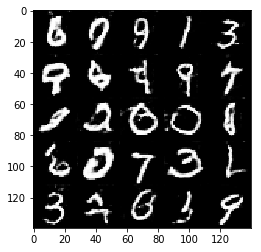

Epoch 2/2... Discriminator Loss: 1.6566... Generator Loss: 0.3670
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.1650
Epoch 2/2... Discriminator Loss: 1.5351... Generator Loss: 2.8036
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 1.1299
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.5978
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 1.2928
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.6024
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 1.4389
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.1274


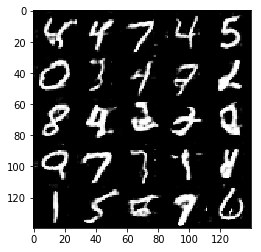

Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.7440... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 2.1276... Generator Loss: 0.2852
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 1.5904
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.3399
Epoch 2/2... Discriminator Loss: 1.1253... Generator Loss: 1.9652
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 1.6246
Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 1.9289


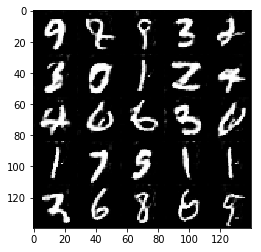

Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 1.0507
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.6104
Epoch 2/2... Discriminator Loss: 1.8347... Generator Loss: 0.3238
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 1.5184... Generator Loss: 0.5238
Epoch 2/2... Discriminator Loss: 0.8405... Generator Loss: 1.3050
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 1.6728
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.8964... Generator Loss: 0.3156


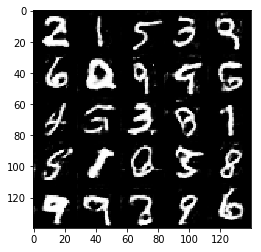

Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 0.8272... Generator Loss: 1.3755
Epoch 2/2... Discriminator Loss: 0.8772... Generator Loss: 1.1829
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 1.3265
Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 1.1069
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.3618
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 2.0686
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 0.9940
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.4854


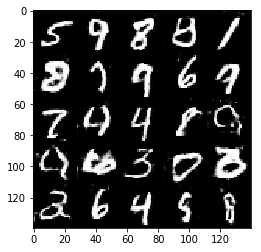

Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 0.8733
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 1.7722
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.0723
Epoch 2/2... Discriminator Loss: 1.5215... Generator Loss: 0.6494
Epoch 2/2... Discriminator Loss: 1.7291... Generator Loss: 0.3845
Epoch 2/2... Discriminator Loss: 1.6322... Generator Loss: 0.3916
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.0440


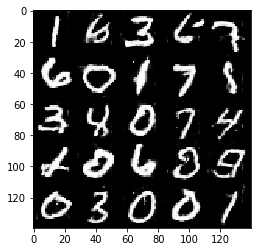

Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.5891
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.6144
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 0.7304... Generator Loss: 1.4799
Epoch 2/2... Discriminator Loss: 1.5227... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.7267
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 1.5964


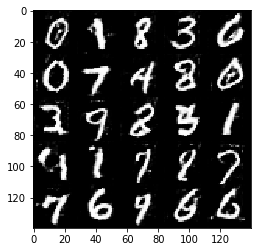

Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.7410
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.8762... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 1.6924
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.6048


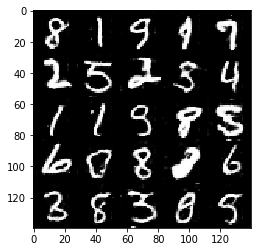

Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.1955
Epoch 2/2... Discriminator Loss: 1.5930... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.6816
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 3.4496
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.6341
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 1.6340


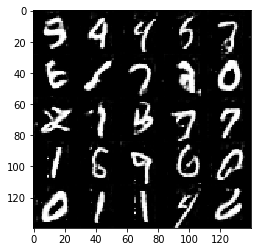

Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 1.1548
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 2.0682
Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.4517... Generator Loss: 0.5566
Epoch 2/2... Discriminator Loss: 0.9811... Generator Loss: 1.0369
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 2.0023
Epoch 2/2... Discriminator Loss: 1.8633... Generator Loss: 0.4563
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 1.7965
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.9489


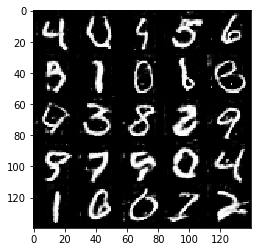

Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.5280
Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 0.9904
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.5254
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 1.7355... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.7163


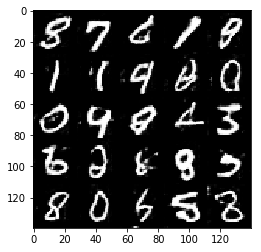

Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.4071
Epoch 2/2... Discriminator Loss: 1.6753... Generator Loss: 0.3834
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.8942


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 9.2834
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 22.0850
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 2.0183
Epoch 1/1... Discriminator Loss: 2.7413... Generator Loss: 0.1645
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 1.4122
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.1442


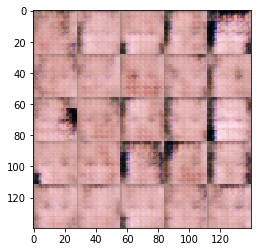

Epoch 1/1... Discriminator Loss: 1.9196... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 1.7378
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.8601... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.8612


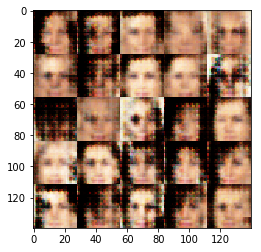

Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 2.2807... Generator Loss: 3.3065
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 1.7636
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 2.0803
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6271


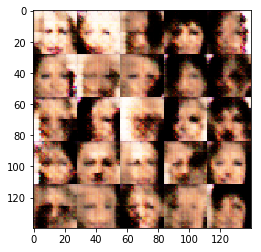

Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.8254
Epoch 1/1... Discriminator Loss: 2.5818... Generator Loss: 0.1623
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 2.7841
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.1481


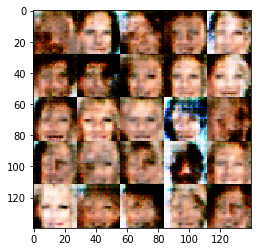

Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.9176... Generator Loss: 0.3040
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.8881... Generator Loss: 0.2765
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 2.0783
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.1381


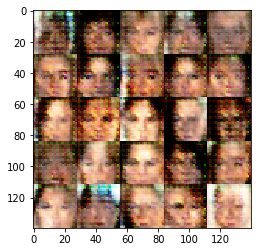

Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.9007


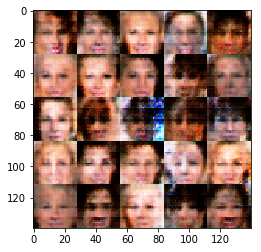

Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.7197... Generator Loss: 2.0719
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.8319


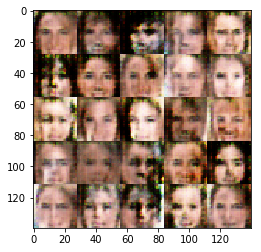

Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 1.2846


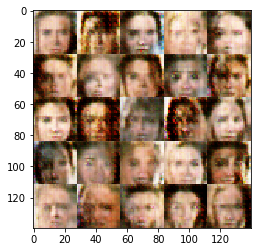

Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 1.4517
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6852


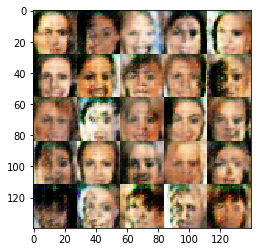

Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9615


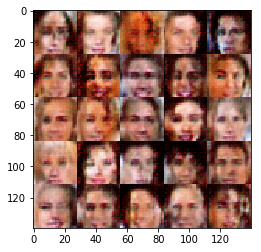

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 1.6336


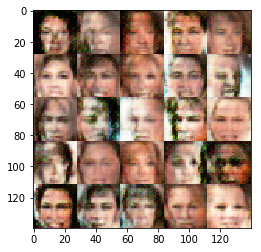

Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7414


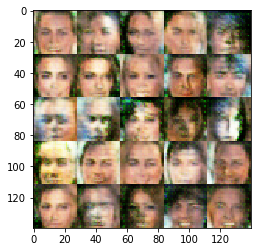

Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.9126


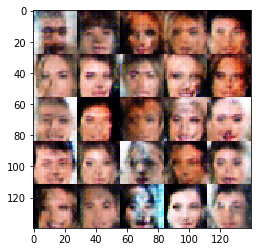

Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.2467


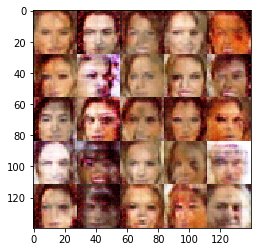

Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0950


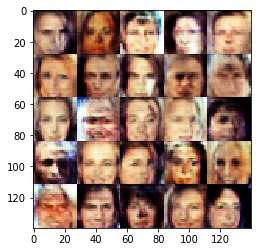

Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6859


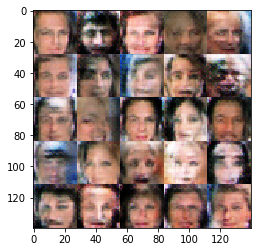

Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.8203


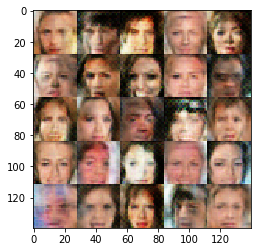

Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.9586


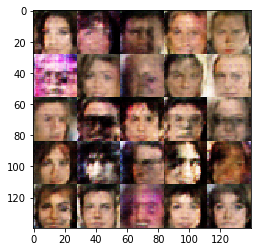

Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9126


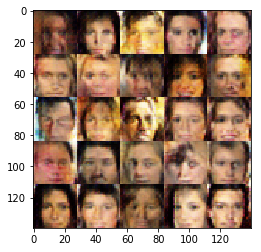

Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8880


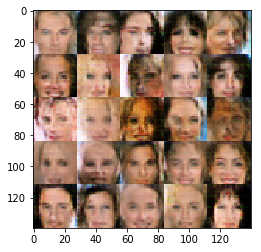

Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8078


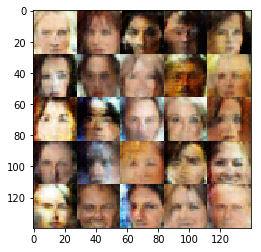

Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.9565


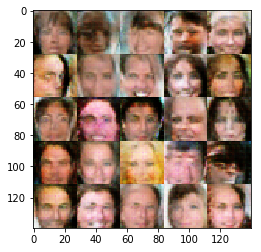

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.4362


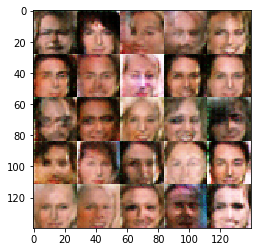

Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.9064


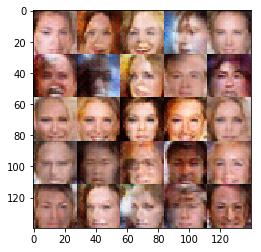

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.2250


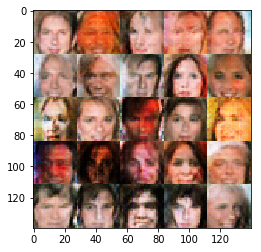

Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5352


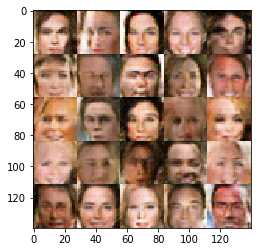

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7919


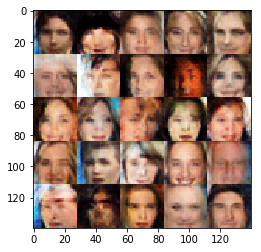

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 1.0042


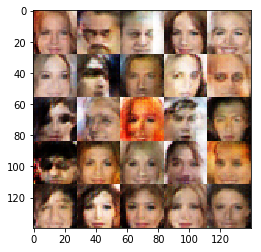

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.8609


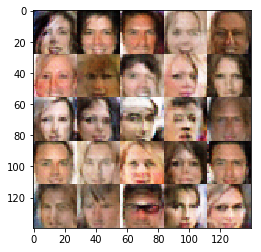

Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.9508


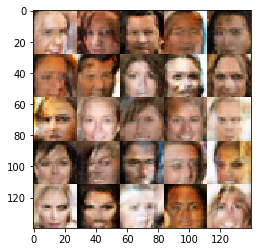

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.9014


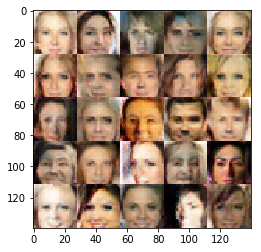

Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9442


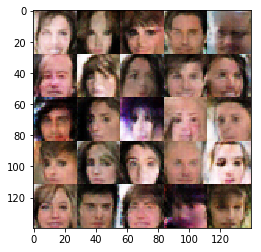

Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.9698


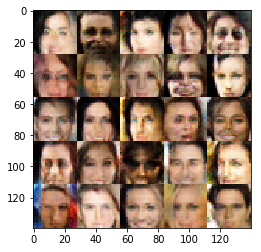

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7520


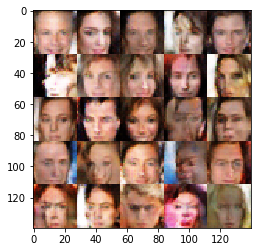

Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9438


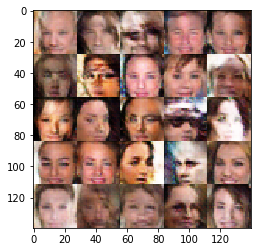

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6328


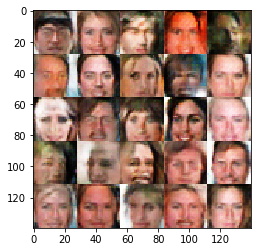

Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5665


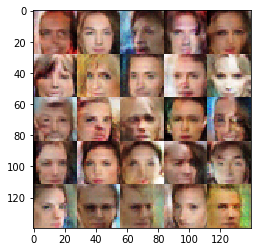

Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8085


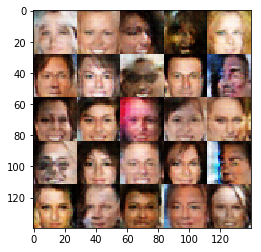

Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6913


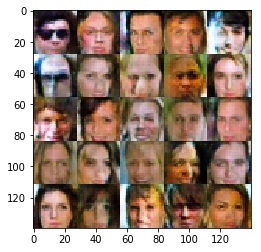

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.7656


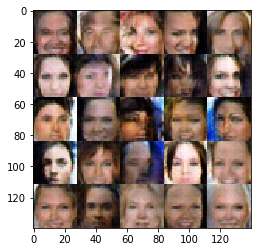

Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6725


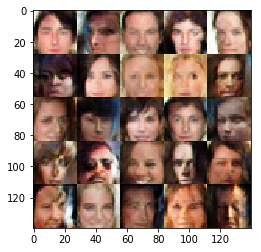

Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7458


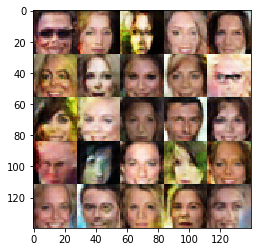

Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8451


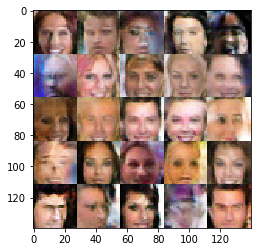

Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.8611


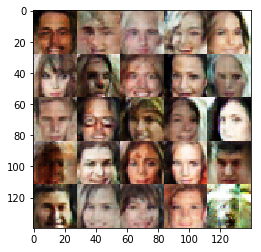

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6910


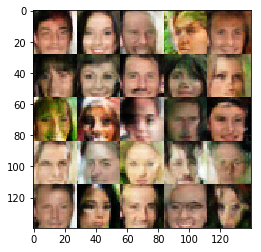

Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6647


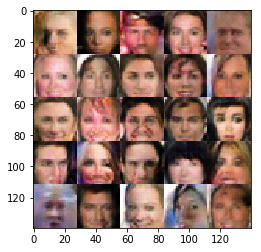

Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.7315


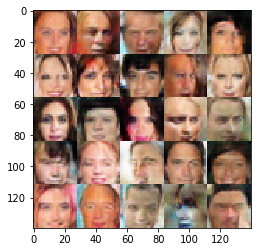

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7494


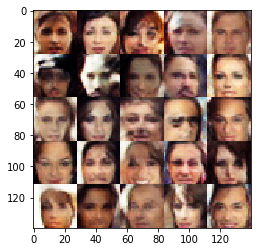

Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6487


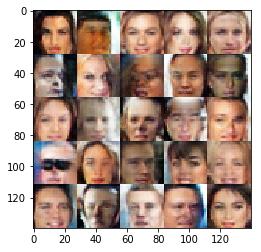

Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.9004


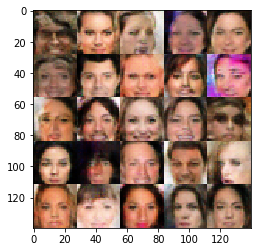

Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8664


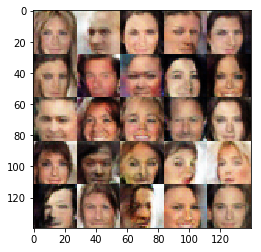

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.9209


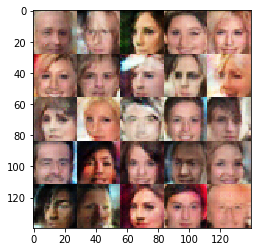

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7794


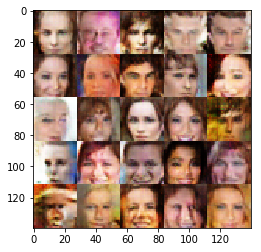

Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8249


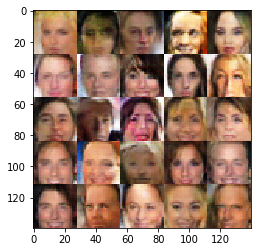

Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.9858


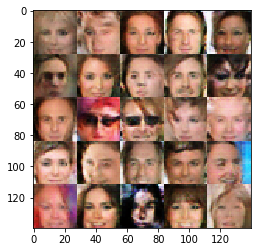

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7101


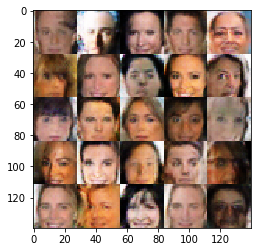

Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8129


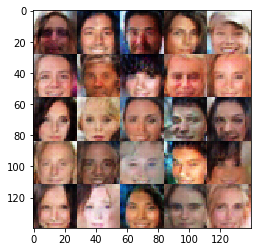

Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.6663... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.0256


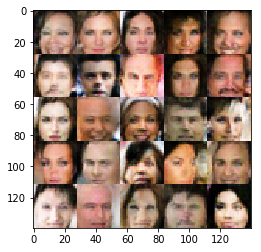

Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8078


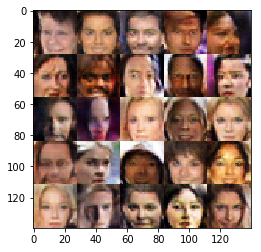

Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7960


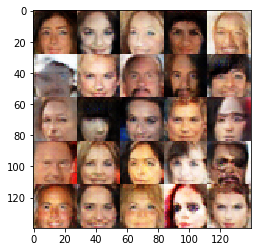

Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6588


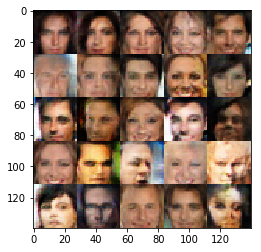

Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.9083


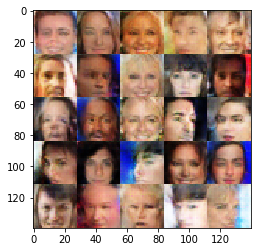

Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7382


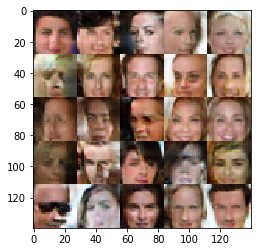

Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.7624


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。